In [1]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
from dataclasses import dataclass
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import skew
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split


def display_table(df, caption, digits=3):
    df_out = df.copy()
    num_cols = df_out.select_dtypes(include=[np.number]).columns
    if len(num_cols) > 0:
        for col in num_cols:
            df_out[col] = df_out[col].map(lambda x: f"{x:.{digits}f}" if pd.notna(x) else "")
    display(Markdown(f"**{caption}**"))
    display(df_out)

# loading data
data_filename = "./installment2_id03.csv"
data_df = pd.read_csv(data_filename)
test_filename = "./installment2_evaluation_data.csv"
test_df = pd.read_csv(test_filename)

In [2]:
# defining utils functions
@dataclass
class ModelMetrics:
    r2: float
    adj_r2: float
    rmse: float
    mae: float
    n_params: int
    model_name: str


def plot_residuals_diagnostics(residuals, fitted_values, model_name, color='lightblue', figsize=(8, 6), name="Figure 2. Residual Diagnostics"):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    axes[0, 0].scatter(fitted_values, residuals, alpha=0.4, s=8)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted PRSM')
    axes[0, 0].set_ylabel('Residual')
    axes[0, 0].set_title(f'{model_name}: Residual vs Fitted')
    axes[0, 0].grid(alpha=0.3)

    sm.qqplot(residuals, line='s', ax=axes[0, 1])
    axes[0, 1].set_title(f'{model_name}: Q-Q Plot')

    axes[1, 0].hist(residuals, bins=40, color=color, edgecolor='black')
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title(f'{model_name}: Residual Distribution')

    std_resid = residuals / residuals.std()
    axes[1, 1].scatter(fitted_values, np.sqrt(np.abs(std_resid)), alpha=0.4, s=8)
    axes[1, 1].set_xlabel('Fitted PRSM')
    axes[1, 1].set_ylabel('Sqrt(|Standardized Residual|)')
    axes[1, 1].set_title(f'{model_name}: Scale-Location')
    axes[1, 1].grid(alpha=0.3)

    plt.suptitle(name, y=1.02)
    plt.tight_layout()
    plt.show()


def _quantile_pi(y_pred, residuals, alpha=0.05):
    q = np.quantile(np.abs(np.asarray(residuals)), 1 - alpha)
    return y_pred - q, y_pred + q


def validate_on_dev_set(model, X_dev, y_dev, model_name, color='blue', model_type='OLS', train_residuals=None):
    y_pred = model.predict(X_dev)
    y_dev_arr = np.asarray(y_dev)

    rmse = np.sqrt(np.mean((y_dev_arr - y_pred) ** 2))
    mae = np.mean(np.abs(y_dev_arr - y_pred))

    if model_type == 'OLS' and hasattr(model, 'get_prediction'):
        try:
            pred_summary = model.get_prediction(X_dev).summary_frame(alpha=0.05)
            pi_lower = pred_summary['obs_ci_lower'].to_numpy()
            pi_upper = pred_summary['obs_ci_upper'].to_numpy()
            pi_method = 'OLS observation interval'
        except Exception:
            residual_source = train_residuals if train_residuals is not None else getattr(model, 'resid', y_dev_arr - y_pred)
            pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
            pi_method = 'Residual-quantile fallback'
    else:
        residual_source = train_residuals if train_residuals is not None else y_dev_arr - y_pred
        pi_lower, pi_upper = _quantile_pi(y_pred, residual_source, alpha=0.05)
        pi_method = 'Residual-quantile interval'

    coverage = np.mean((y_dev_arr >= pi_lower) & (y_dev_arr <= pi_upper))

    dev_metrics = {
        'Model': model_name,
        'DevRMSE': rmse,
        'DevMAE': mae,
        'PI95Coverage': coverage,
        'IntervalMethod': pi_method,
    }
    return rmse, mae, coverage, dev_metrics


def fit_ols_model(X_train, y_train, model_name='OLS Model'):
    if 'const' not in X_train.columns:
        X_train = sm.add_constant(X_train)

    model = sm.OLS(y_train, X_train).fit()

    r2 = model.rsquared
    adj_r2 = model.rsquared_adj
    n_params = int(model.df_model)

    train_metrics = {
        'Model': model_name,
        'TrainR2': r2,
        'TrainAdjR2': adj_r2,
        'ParamCount': n_params,
    }
    return model, {'r2': r2, 'adj_r2': adj_r2, 'n_params': n_params, 'train_metrics': train_metrics}


def _cv_rmse(X, y, cv_splitter):
    model = LinearRegression()
    rmse_scores = -cross_val_score(
        model,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=cv_splitter,
    )
    return float(np.mean(rmse_scores))


def backward_stepwise_selection(X_train, y_train, threshold_p=0.05, cv=5, random_state=42, min_improvement=1e-4):
    use_const = 'const' in X_train.columns
    predictors = [c for c in X_train.columns if c != 'const']

    if len(predictors) == 0:
        raise ValueError('No predictors available for stepwise selection.')

    cv_splitter = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    current_rmse = _cv_rmse(X_train[predictors], y_train, cv_splitter)
    initial_rmse = current_rmse
    initial_count = len(predictors)

    removed_features = []

    while len(predictors) > 1:
        candidate_results = []
        for feature in predictors:
            candidate_predictors = [p for p in predictors if p != feature]
            rmse_candidate = _cv_rmse(X_train[candidate_predictors], y_train, cv_splitter)
            candidate_results.append((feature, rmse_candidate))

        feature_to_remove, best_candidate_rmse = min(candidate_results, key=lambda x: x[1])

        if current_rmse - best_candidate_rmse > min_improvement:
            predictors.remove(feature_to_remove)
            removed_features.append(feature_to_remove)
            current_rmse = best_candidate_rmse
        else:
            break

    X_final = X_train[predictors].copy()
    if use_const:
        X_final = sm.add_constant(X_final, has_constant='add')

    final_model = sm.OLS(y_train, X_final).fit()

    stepwise_summary = pd.DataFrame({
        'InitialPredictorCount': [initial_count],
        'FinalPredictorCount': [len(predictors)],
        'InitialCVRMSE': [initial_rmse],
        'FinalCVRMSE': [current_rmse],
        'RemovedPredictors': [', '.join(removed_features) if removed_features else 'None'],
    })

    return predictors, final_model, stepwise_summary


def fit_lasso_model(X_train, y_train, features_list, model_name='LASSO Model'):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    cv_splitter = KFold(n_splits=5, shuffle=True, random_state=42)
    lasso_cv = LassoCV(cv=cv_splitter, random_state=42, max_iter=10000, n_alphas=100)
    lasso_cv.fit(X_train_scaled, y_train)

    optimal_alpha = float(lasso_cv.alpha_)

    y_pred = lasso_cv.predict(X_train_scaled)
    r2 = r2_score(y_train, y_pred)
    n = len(y_train)
    p = int(np.sum(lasso_cv.coef_ != 0))

    if n - p - 1 > 0:
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    else:
        adj_r2 = np.nan

    lasso_coefs = pd.DataFrame({'Predictor': features_list, 'Coefficient': lasso_cv.coef_})
    lasso_coefs['AbsCoefficient'] = np.abs(lasso_coefs['Coefficient'])
    lasso_coefs = lasso_coefs.sort_values('AbsCoefficient', ascending=False)

    residuals = np.asarray(y_train) - y_pred

    train_metrics = {
        'Model': model_name,
        'TrainR2': r2,
        'TrainAdjR2': adj_r2,
        'ParamCount': p,
        'OptimalAlpha': optimal_alpha,
    }

    return lasso_cv, scaler, {
        'r2': r2,
        'adj_r2': adj_r2,
        'n_params': p,
        'optimal_alpha': optimal_alpha,
        'coefficients': lasso_coefs,
        'train_residuals': residuals,
        'train_metrics': train_metrics,
    }

**Author:** Eva Song and Eton Tackett

# Background

A local credit union provides 12-month loans to small businesses that often lack strong credit histories, with repayment collected as a fixed percentage of the business’s monthly credit card sales, including both principal and interest. Because payments depend on fluctuating sales, repayment progress can vary significantly over time, creating uncertainty in borrowers’ ability to repay their loans. To better monitor repayment and identify borrowers at risk of falling behind, the credit union developed a metric called PRSM, defined as twice the proportion of the total loan amount repaid after six months. Due to the variability and uncertainty in repayment, the goal is to predict the PRSM score using available borrower and business features to improve risk assessment and decision-making. In this project, we were asked to build a multiple regression model to accurately predict credit risk for a credit union lending loans to small businesses. 


# Data preprocessing

We begin with data preprocessing and exploratory data analysis (EDA) to ensure data quality and suitability for subsequent modeling. No missing values were identified in the dataset.

We applied several data cleaning steps based on domain constraints rather than statistical outlier detection. Specifically, FICO scores were restricted to the valid range [300, 800], and observations with negative values of `PRSM` or `Stress` were removed. PRSM is defined as a repayment ratio and is therefore non-negative by construction, while Stress is also a ratio for which negative values are not meaningful. These filtering steps ensure that all retained observations are consistent with the underlying definitions of the variables.

To improve feature representation of credit risk, we constructed a ratio variable capturing the proportion of delinquent credit lines:

$$\text{Prop\_Delinquent} = \frac{\text{Num\_Delinquent}}{\text{Num\_CreditLines}}$$

This ratio provides a more informative measure than the raw count alone, as it accounts for the total number of credit lines. For example, one delinquent line out of ten total lines represents a substantially lower risk profile than four delinquent lines out of five.

We assessed multicollinearity using variance inflation factors (VIF). As shown in Tables 1a and 1b, `Num_Delinquent` exhibits high collinearity with the constructed ratio variable and was therefore excluded from the model. After removal, all remaining predictors have VIF values below 3 (maximum VIF = 2.51), indicating no serious multicollinearity concerns.

For categorical variables, we applied one-hot encoding to `CorpStructure` and `NAICS_industry`. To reduce dimensionality and avoid sparse categories, NAICS codes were aggregated to the sector level using the first two digits. In addition, we discretized `FICO` scores into five ordinal categories (0–4), where higher values indicate better credit quality, following standard credit score ranges (Experian, 2023). This transformation allows for potential nonlinear effects while maintaining interpretability.

Several continuous predictors, including `TotalAmtOwed`, `Months`, and `Volume`, exhibited substantial right skewness (see Figure 1). To mitigate skewness and stabilize variance, we applied log transformations to these variables. However, since such transformations may not necessarily improve the fit of linear models, we retain both raw-scale and log-transformed specifications. Subsequent model comparison evaluates whether the transformation leads to improved predictive performance.

In [3]:
# data cleaning
fico_out = data_df[(data_df['FICO'] < 300) | (data_df['FICO'] > 850)]
prsm_neg = data_df[data_df['PRSM'] < 0]
stress_neg = data_df[data_df['Stress'] < 0]
num_delinq_gt_credit = data_df[data_df['Num_Delinquent'] > data_df['Num_CreditLines']]

quality_table = pd.DataFrame({
    'Check': [
        'FICO outside [300, 850]',
        'PRSM below 0',
        'Stress below 0',
        'Num_Delinquent > Num_CreditLines',
        'Rows removed due to invalid PRSM'
    ],
    'Count': [
        len(fico_out),
        len(prsm_neg),
        len(stress_neg),
        len(num_delinq_gt_credit),
        len(prsm_neg)
    ]
})

data_df = data_df[data_df['PRSM'] >= 0]


# feature engineering
data_df['Prop_Delinquent_Credit'] = data_df['Num_Delinquent'] / data_df['Num_CreditLines']
test_df['Prop_Delinquent_Credit'] = test_df['Num_Delinquent'] / test_df['Num_CreditLines']

FICO_map = {
    0: (300, 579),
    1: (580, 669),
    2: (670, 739),
    3: (740, 799),
    4: (800, 850)
}
data_df['FICO_category'] = data_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))
test_df['FICO_category'] = test_df['FICO'].apply(lambda x: next((cat for cat, (low, high) in FICO_map.items() if low <= x <= high), np.nan))

naics_industry_map = {
    11: 'Agriculture, Forestry, Fishing and Hunting',
    21: 'Mining',
    22: 'Utilities',
    23: 'Construction',
    31: 'Manufacturing',
    32: 'Manufacturing',
    33: 'Manufacturing',
    42: 'Wholesale Trade',
    44: 'Retail Trade',
    45: 'Retail Trade',
    48: 'Transportation and Warehousing',
    49: 'Transportation and Warehousing',
    51: 'Information',
    52: 'Finance and Insurance',
    53: 'Real Estate Rental and Leasing',
    54: 'Professional, Scientific, and Technical Services',
    55: 'Management of Companies and Enterprises',
    56: 'Administrative and Support and Waste Management Services',
    61: 'Educational Services',
    62: 'Health Care and Social Assistance',
    71: 'Arts, Entertainment, and Recreation',
    72: 'Accommodation and Food Services',
    81: 'Other Services (except Public Administration)',
    92: 'Public Administration'
}

data_df['NAICS_2digit'] = (data_df['NAICS'] // 10000).astype(int)
data_df['NAICS_industry'] = data_df['NAICS_2digit'].map(naics_industry_map)

test_df['NAICS_2digit'] = (test_df['NAICS'] // 10000).astype(int)
test_df['NAICS_industry'] = test_df['NAICS_2digit'].map(naics_industry_map)

data_df = pd.concat([data_df, pd.get_dummies(data_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(data_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(data_df['NAICS'], prefix='NAICS_code')], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df['CorpStructure'], prefix='CorpStructure'), pd.get_dummies(test_df['NAICS_industry'], prefix='NAICS_ind'), pd.get_dummies(test_df['NAICS'], prefix='NAICS_code')], axis=1)

In [4]:
# multicollinearity check
numeric_predictors_without_delinq = [
    'TotalAmtOwed',
    'Volume',
    'Stress',
    'Num_CreditLines',
    'Prop_Delinquent_Credit',
    'Months'
]
numeric_predictors_with_deliq = [
    'TotalAmtOwed',
    'Volume',
    'Stress',
    'Num_CreditLines',
    'Num_Delinquent',
    'Prop_Delinquent_Credit',
    'Months'
]

X_vif = data_df[numeric_predictors_with_deliq]
X_vif = X_vif.assign(const=1)

vif_df = pd.DataFrame({
    'Variable': numeric_predictors_with_deliq,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(len(numeric_predictors_with_deliq))]
}).sort_values('VIF', ascending=False)
display_table(vif_df, 'Table 1a. Variance Inflation Factor with Num_Delinquent')

X_vif_no_delinq = data_df[numeric_predictors_without_delinq]
X_vif_no_delinq = X_vif_no_delinq.assign(const=1)
vif_no_delinq_df = pd.DataFrame({
    'Variable': numeric_predictors_without_delinq,
    'VIF': [variance_inflation_factor(X_vif_no_delinq.values, i) for i in range(len(numeric_predictors_without_delinq))]
}).sort_values('VIF', ascending=False)
display_table(vif_no_delinq_df, 'Table 1b. Variance Inflation Factor without Num_Delinquent')

**Table 1a. Variance Inflation Factor with Num_Delinquent**

,Variable,VIF
5,Prop_Delinquent_Credit,44.630
3,Num_CreditLines,22.862
4,Num_Delinquent,18.078
1,Volume,1.358
0,TotalAmtOwed,1.224
2,Stress,1.153
6,Months,1.001


**Table 1b. Variance Inflation Factor without Num_Delinquent**

,Variable,VIF
4,Prop_Delinquent_Credit,2.511
3,Num_CreditLines,2.510
1,Volume,1.357
0,TotalAmtOwed,1.223
2,Stress,1.151
5,Months,1.001


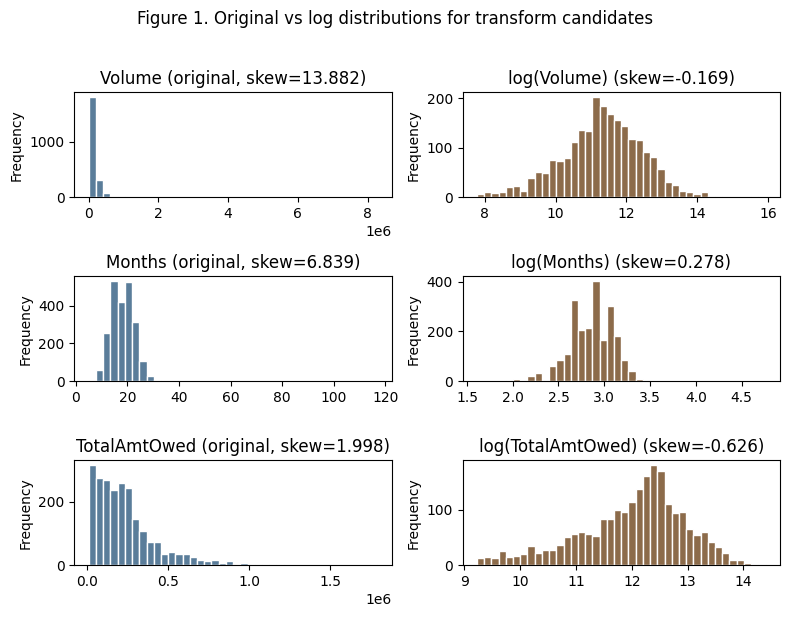

In [5]:
# distribution check and transformation
vars_to_check = ['TotalAmtOwed', 'Volume', 'Stress',
                 'Num_CreditLines', 'Prop_Delinquent_Credit', 'Months']

# Compute skewness
skew_df = pd.DataFrame({
    'Variable': vars_to_check,
    'Skewness': [skew(data_df[v]) for v in vars_to_check],
    'Min': [data_df[v].min() for v in vars_to_check],
    'Max': [data_df[v].max() for v in vars_to_check],
    'Median': [data_df[v].median() for v in vars_to_check],
    'Mean': [data_df[v].mean() for v in vars_to_check],
})
# display_table(skew_df, 'Table 3. Distribution summary for continuous predictors')

# Plot original vs log-transformed distributions for candidate variables
candidates_for_log = ['Volume', 'Months', 'TotalAmtOwed']  # financial vars likely to be right-skewed

fig, axes = plt.subplots(len(candidates_for_log), 2, figsize=(8, 2 * len(candidates_for_log)))
for i, var in enumerate(candidates_for_log):
    vals = data_df[var]
    vals_pos = vals[vals > 0]

    axes[i, 0].hist(vals, bins=40, color='#5A7D9A', edgecolor='white')
    axes[i, 0].set_title(f'{var} (original, skew={skew(vals):.3f})')
    axes[i, 0].set_ylabel('Frequency')

    axes[i, 1].hist(np.log(vals_pos), bins=40, color='#8C6B4A', edgecolor='white')
    axes[i, 1].set_title(f'log({var}) (skew={skew(np.log(vals_pos)):.3f})')
    axes[i, 1].set_ylabel('Frequency')

fig.suptitle('Figure 1. Original vs log distributions for transform candidates', y=1.02)
plt.tight_layout()
plt.show()

# solution: log-transform for 'Volume', 'Months', 'TotalAmtOwed'
for var in candidates_for_log:
    data_df[f'log_{var}'] = np.log(data_df[var].where(data_df[var] > 0))
    test_df[f'log_{var}'] = np.log(test_df[var].where(test_df[var] > 0))

# Modeling

We split the dataset into training and validation sets using an 80:20 ratio. The training set is used for model fitting and variable selection, while the validation set is reserved for out-of-sample model comparison.

To evaluate modeling choices in a structured manner, we consider three regression methods—ordinary least squares (OLS), LASSO, and backward stepwise regression—under two feature specifications: (i) raw-scale predictors and (ii) log-transformed predictors for selected variables. This results in a 2 × 3 modeling design, allowing us to assess the impact of both model class and feature transformation on predictive performance.

As a baseline, we fit an OLS model using raw-scale predictors without log transformation. Diagnostic plots for this model (Figure 2) indicate the presence of observations with large standardized residuals.

Observations with standardized residuals exceeding 0.5 were identified as potential outliers and removed from the dataset. All subsequent models were refitted using the cleaned data. This procedure aims to reduce the influence of extreme observations on model estimation. However, we note that the threshold used for defining outliers is relatively conservative and primarily motivated by diagnostic inspection rather than a formal statistical rule.

In [6]:
# split train/dev sets
train_df, dev_df = train_test_split(data_df, test_size=0.2, random_state=628)

train_df.to_csv('./train_df.csv', index=False)
dev_df.to_csv('./dev_df.csv', index=False)
test_df.to_csv('./test_df.csv', index=False)

train_df = pd.read_csv('./train_df.csv')
dev_df = pd.read_csv('./dev_df.csv')
test_df = pd.read_csv('./test_df.csv')

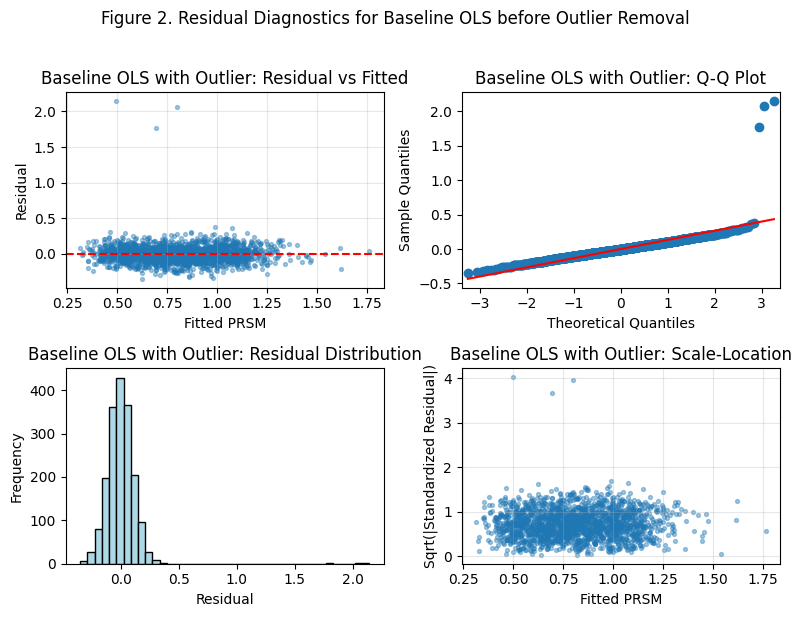

In [7]:
# Model 0: Baseline OLS (without log transformation)
base_predictors = ['FICO_category', 'TotalAmtOwed', 'Volume', 'Stress', 'Num_CreditLines', 'Prop_Delinquent_Credit','WomanOwned', 'Months', 'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner', 'NAICS_ind_Retail Trade']

X_train_base = train_df[base_predictors].copy().astype(float)
X_train_base_with_const = sm.add_constant(X_train_base)
X_dev_base = dev_df[base_predictors].copy().astype(float)
X_dev_base_with_const = sm.add_constant(X_dev_base)
y_train = train_df['PRSM'].astype(float)
y_dev = dev_df['PRSM'].astype(float)

model_baselineOLS, metrics_baselineOLS = fit_ols_model(X_train_base_with_const, y_train, 'Model 0 Baseline OLS, raw predictors')

baselineOLS_r2 = metrics_baselineOLS['r2']
baselineOLS_adj_r2 = metrics_baselineOLS['adj_r2']

model0_train_table = pd.DataFrame([metrics_baselineOLS['train_metrics']])
# display_table(model0_train_table, 'Table M0A. Model 0 training metrics')

residuals_baselineOLS = model_baselineOLS.resid
fitted_baselineOLS = model_baselineOLS.fittedvalues
plot_residuals_diagnostics(residuals_baselineOLS, fitted_baselineOLS, 'Baseline OLS with Outlier', color='lightblue', name="Figure 2. Residual Diagnostics for Baseline OLS before Outlier Removal")

The set of candidate predictors is fixed across all models to ensure comparability. For the raw-scale specification, the predictors include: `TotalAmtOwed`, `Volume`, `Months`, `Stress`, `Num_CreditLines`, `Prop_Delinquent_Credit`, `FICO_category`, `WomanOwned`, `CorpStructure_Corp`, `CorpStructure_LLC`, `CorpStructure_Partner`, and `NAICS_RetailTrade`. For the log-transformed specification, log transformations are applied to `TotalAmtOwed`, `Volume`, and `Months`, while all other variables remain unchanged. This parallel setup allows us to isolate the effect of transformation on model performance without confounding it with changes in the feature set.

Model performance is evaluated on the validation set using root mean squared error (RMSE) and prediction interval (PI) coverage. RMSE measures predictive accuracy, while PI coverage assesses the calibration of uncertainty estimates relative to the nominal 95% level.

As shown in Table 6, models using raw-scale predictors consistently outperform their log-transformed counterparts, achieving lower RMSE and coverage levels closer to the nominal target. This suggests that, in this dataset, log transformation does not improve predictive performance.

Among all models, the LASSO model without log transformation achieves the lowest RMSE (approximately 0.217) while maintaining prediction interval coverage near 95%, making it the selected model.

In [8]:
# Model 0 refinement: outlier trimming based on residual threshold
outlier_threshold = 0.5
abs_residuals = np.abs(residuals_baselineOLS)
outlier_mask = abs_residuals > outlier_threshold
outlier_indices = np.where(outlier_mask)[0]

model0_outlier_summary = pd.DataFrame({
    'Metric': ['ResidualThreshold', 'OutlierCount', 'TrainRowsBeforeTrim'],
    'Value': [outlier_threshold, len(outlier_indices), len(X_train_base)],
})

if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_baselineOLS.iloc[outlier_indices].values,
        'Residual': residuals_baselineOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    }).sort_values('Abs_Residual', ascending=False).head(20)
else:
    outlier_data = pd.DataFrame(columns=['Index', 'Actual_PRSM', 'Predicted_PRSM', 'Residual', 'Abs_Residual'])

inlier_mask = (~outlier_mask).values
X_train_base_del = X_train_base[inlier_mask].copy().astype(float)
X_train_base_with_const_del = sm.add_constant(X_train_base_del)
y_train_base_del = y_train[inlier_mask].copy().astype(float)

model_baselineOLS_del, metrics_baselineOLS_del = fit_ols_model(X_train_base_with_const_del, y_train_base_del, 'Model 0 Trimmed OLS')

baselineOLS_del_r2 = metrics_baselineOLS_del['r2']
baselineOLS_del_adj_r2 = metrics_baselineOLS_del['adj_r2']

model0_trim_train_table = pd.DataFrame([metrics_baselineOLS_del['train_metrics']])

residuals_baselineOLS_del = model_baselineOLS_del.resid
fitted_baselineOLS_del = model_baselineOLS_del.fittedvalues

rmse_baselineOLS_del, mae_baselineOLS_del, coverage_baselineOLS_del, metrics_m0_dev = validate_on_dev_set(
    model_baselineOLS_del, X_dev_base_with_const, y_dev, 'Model 0 Trimmed OLS', 'blue', model_type='OLS')

In [9]:
# Model 1: Baseline LASSO (without log transformation)
model_baselineLASSO, scaler_baselineLASSO, metrics_baselineLASSO = fit_lasso_model(
    X_train_base_del, y_train_base_del, base_predictors, 'Model 1 Baseline LASSO, raw predictors'
)

baselineLASSO_r2 = metrics_baselineLASSO['r2']
baselineLASSO_adj_r2 = metrics_baselineLASSO['adj_r2']
lasso_coefs_baselineLASSO = metrics_baselineLASSO['coefficients']

model1_train_table = pd.DataFrame([metrics_baselineLASSO['train_metrics']])

model1_coef_table = lasso_coefs_baselineLASSO.copy()
    #lasso_coefs_baselineLASSO['Coefficient'] != 0
    

X_train_lasso_scaled = scaler_baselineLASSO.transform(X_train_base_del)
y_pred_train_baselineLASSO = model_baselineLASSO.predict(X_train_lasso_scaled)

residuals_baselineLASSO = y_train_base_del - y_pred_train_baselineLASSO
fitted_baselineLASSO = y_pred_train_baselineLASSO


X_dev_lasso_scaled = scaler_baselineLASSO.transform(X_dev_base)
rmse_baselineLASSO, mae_baselineLASSO, coverage_baselineLASSO, metrics_m1_dev = validate_on_dev_set(
    model_baselineLASSO, X_dev_lasso_scaled, y_dev, 'Model 1 Baseline LASSO, raw predictors', 'blue', 
    model_type='LASSO', train_residuals=metrics_baselineLASSO['train_residuals'])

model1_dev_table = pd.DataFrame([metrics_m1_dev])


In [10]:
# Model 2: Baseline Stepwise OLS (without log transformation)
stepwise_predictors_baselineStep, model_baselineStep, stepwise_summary_baseline = backward_stepwise_selection(
    X_train_base_with_const_del, y_train_base_del, threshold_p=0.05)

baselineStep_r2 = model_baselineStep.rsquared
baselineStep_adj_r2 = model_baselineStep.rsquared_adj

model2_train_table = pd.DataFrame([{
    'Model': 'Model 2 Baseline Stepwise OLS',
    'TrainR2': baselineStep_r2,
    'TrainAdjR2': baselineStep_adj_r2,
    'ParamCount': int(model_baselineStep.df_model),
}])

stepwise_summary_baseline = stepwise_summary_baseline
stepwise_summary_baseline['InitialCVRMSE'] = stepwise_summary_baseline['InitialCVRMSE'].astype(float)
stepwise_summary_baseline['FinalCVRMSE'] = stepwise_summary_baseline['FinalCVRMSE'].astype(float)

stepwise_coef_table = (
    model_baselineStep.params
    .drop('const', errors='ignore')
    .rename('coef')
    .reset_index()
    .rename(columns={'index': 'predictor'})
)

residuals_baselineStep = model_baselineStep.resid
fitted_baselineStep = model_baselineStep.fittedvalues

X_dev_baselineStep = dev_df[stepwise_predictors_baselineStep].copy().astype(float)
X_dev_baselineStep = sm.add_constant(X_dev_baselineStep)

rmse_baselineStep, mae_baselineStep, coverage_baselineStep, metrics_m2_dev = validate_on_dev_set(
    model_baselineStep, X_dev_baselineStep, y_dev, 'Model 2 Baseline Stepwise OLS', 'blue', model_type='OLS')

model2_dev_table = pd.DataFrame([metrics_m2_dev])


In [11]:
# Model 3: Preprocessed OLS (with log transformation)
preprocessed_predictors = ['FICO_category', 'log_TotalAmtOwed', 'log_Volume', 'Stress', 'log_Months',
                   'Num_CreditLines', 'Prop_Delinquent_Credit', 'WomanOwned',
                   'CorpStructure_Corp', 'CorpStructure_LLC', 'CorpStructure_Partner',
                   'NAICS_ind_Retail Trade']

X_train_preprocessed = train_df[preprocessed_predictors].copy().astype(float)
X_train_preprocessed_with_const = sm.add_constant(X_train_preprocessed)
X_dev_preprocessed = dev_df[preprocessed_predictors].copy().astype(float)
X_dev_preprocessed_with_const = sm.add_constant(X_dev_preprocessed)

model_preOLS, metrics_preOLS = fit_ols_model(X_train_preprocessed_with_const, y_train, 'Model 3 Preprocessed OLS, log predictors')

preOLS_r2 = metrics_preOLS['r2']
preOLS_adj_r2 = metrics_preOLS['adj_r2']

model3_train_table = pd.DataFrame([metrics_preOLS['train_metrics']])

residuals_preOLS = model_preOLS.resid
fitted_preOLS = model_preOLS.fittedvalues

# Model 3 refinement: outlier trimming for preprocessed OLS
outlier_pre_threshold = 0.5
abs_residuals = np.abs(residuals_preOLS)
outlier_mask = abs_residuals > outlier_pre_threshold
outlier_indices = np.where(outlier_mask)[0]

model3_outlier_summary = pd.DataFrame({
    'Metric': ['ResidualThreshold', 'OutlierCount', 'TrainRowsBeforeTrim'],
    'Value': [outlier_pre_threshold, len(outlier_indices), len(X_train_preprocessed)],
})

if len(outlier_indices) > 0:
    outlier_data = pd.DataFrame({
        'Index': outlier_indices,
        'Actual_PRSM': y_train.iloc[outlier_indices].values,
        'Predicted_PRSM': fitted_preOLS.iloc[outlier_indices].values,
        'Residual': residuals_preOLS.iloc[outlier_indices].values,
        'Abs_Residual': abs_residuals.iloc[outlier_indices].values
    }).sort_values('Abs_Residual', ascending=False).head(20)
else:
    outlier_data = pd.DataFrame(columns=['Index', 'Actual_PRSM', 'Predicted_PRSM', 'Residual', 'Abs_Residual'])

inlier_mask = (~outlier_mask).values
X_train_preprocessed_del = X_train_preprocessed[inlier_mask].copy().astype(float)
X_train_preprocessed_with_const_del = sm.add_constant(X_train_preprocessed_del)
y_train_preprocessed_del = y_train[inlier_mask].copy().astype(float)

model_preOLS_del, metrics_preOLS_del = fit_ols_model(X_train_preprocessed_with_const_del, y_train_preprocessed_del, 'Model 3 Trimmed Preprocessed OLS')

preOLS_del_r2 = metrics_preOLS_del['r2']
preOLS_del_adj_r2 = metrics_preOLS_del['adj_r2']

model3_trim_train_table = pd.DataFrame([metrics_preOLS_del['train_metrics']]).round(3)

residuals_preOLS_del = model_preOLS_del.resid
fitted_preOLS_del = model_preOLS_del.fittedvalues

rmse_preOLS_del, mae_preOLS_del, coverage_preOLS_del, metrics_m3_dev = validate_on_dev_set(
    model_preOLS_del, X_dev_preprocessed_with_const, y_dev, 'Model 3 Trimmed Preprocessed OLS', 'blue', model_type='OLS')

model3_dev_table = pd.DataFrame([metrics_m3_dev]).round(3)

In [12]:
# Model 4: Preprocessed Stepwise OLS (with log transformation)
stepwise_predictors_preStep, model_preStep, stepwise_summary_pre = backward_stepwise_selection(
    X_train_preprocessed_with_const_del, y_train_preprocessed_del, threshold_p=0.05)

preStep_r2 = model_preStep.rsquared
preStep_adj_r2 = model_preStep.rsquared_adj

model4_train_table = pd.DataFrame([{
    'Model': 'Model 4 Preprocessed Stepwise OLS',
    'TrainR2': preStep_r2,
    'TrainAdjR2': preStep_adj_r2,
    'ParamCount': int(model_preStep.df_model),
}]).round(3)

stepwise_summary_pre = stepwise_summary_pre.round(3)

stepwise_pre_coef_table = (
    model_preStep.params
    .drop('const', errors='ignore')
    .rename('coef')
    .reset_index()
    .rename(columns={'index': 'predictor'})
).round(3)

residuals_preStep = model_preStep.resid
fitted_preStep = model_preStep.fittedvalues

X_dev_preStep = dev_df[stepwise_predictors_preStep].copy().astype(float)
X_dev_preStep = sm.add_constant(X_dev_preStep)

rmse_preStep, mae_preStep, coverage_preStep, metrics_m4_dev = validate_on_dev_set(
    model_preStep, X_dev_preStep, y_dev, 'Model 4 Preprocessed Stepwise OLS', 'blue', model_type='OLS')

model4_dev_table = pd.DataFrame([metrics_m4_dev]).round(3)




In [13]:
# Model 5: Preprocessed LASSO (with log transformation)
model_preLASSO, scaler_preLASSO, metrics_preLASSO = fit_lasso_model(
    X_train_preprocessed_del, y_train_preprocessed_del, preprocessed_predictors, 'Model 5 Preprocessed LASSO, log predictors'
)

preLASSO_r2 = metrics_preLASSO['r2']
preLASSO_adj_r2 = metrics_preLASSO['adj_r2']
lasso_coefs_preLASSO = metrics_preLASSO['coefficients']

model5_train_table = pd.DataFrame([metrics_preLASSO['train_metrics']]).round(3)

model5_coef_table = lasso_coefs_preLASSO[lasso_coefs_preLASSO['Coefficient'] != 0].copy().round(3)

X_train_preLASSO_scaled = scaler_preLASSO.transform(X_train_preprocessed_del)
y_pred_train_preLASSO = model_preLASSO.predict(X_train_preLASSO_scaled)

residuals_preLASSO = y_train_preprocessed_del - y_pred_train_preLASSO
fitted_preLASSO = y_pred_train_preLASSO

X_dev_preLASSO_scaled = scaler_preLASSO.transform(X_dev_preprocessed)
rmse_preLASSO, mae_preLASSO, coverage_preLASSO, metrics_m5_dev = validate_on_dev_set(
    model_preLASSO, X_dev_preLASSO_scaled, y_dev, 'Model 5 Preprocessed LASSO', 'blue',
    model_type='LASSO', train_residuals=metrics_preLASSO['train_residuals']
)

model5_dev_table = pd.DataFrame([metrics_m5_dev]).round(3)

In [24]:
# Comprehensive comparison table
comparison = pd.DataFrame({
    'Model': [
        'Baseline OLS',
        'Baseline LASSO',
        'Baseline Stepwise',
        'OLS',
        'LASSO',
        'Stepwise',
    ],
    'Transformation': ['NoLog', 'NoLog', 'NoLog', 'Log', 'Log', 'Log'],
    'TrainR2': [baselineOLS_del_r2, baselineLASSO_r2, baselineStep_r2, preOLS_del_r2, preLASSO_r2, preStep_r2],
    'AdjR2': [baselineOLS_del_adj_r2, baselineLASSO_adj_r2, baselineStep_adj_r2, preOLS_del_adj_r2, preLASSO_adj_r2, preStep_adj_r2],
    'DevRMSE': [rmse_baselineOLS_del, rmse_baselineLASSO, rmse_baselineStep, rmse_preOLS_del, rmse_preLASSO, rmse_preStep],
    'DevMAE': [mae_baselineOLS_del, mae_baselineLASSO, mae_baselineStep, mae_preOLS_del, mae_preLASSO, mae_preStep],
    'PI Coverage': [
        coverage_baselineOLS_del * 100,
        coverage_baselineLASSO * 100,
        coverage_baselineStep * 100,
        coverage_preOLS_del * 100,
        coverage_preLASSO * 100,
        coverage_preStep * 100
    ],
})

# Show full-precision table for transparent model ranking
comparison_view = comparison.copy()
display_table(comparison_view, 'Table 2. Model comparison on validation set', digits=4)


**Table 2. Model comparison on validation set**

,Model,Transformation,TrainR2,AdjR2,DevRMSE,DevMAE,PI Coverage
0,Baseline OLS,NoLog,0.8264,0.8253,0.2168,0.1029,94.9115
1,Baseline LASSO,NoLog,0.8263,0.8252,0.2166,0.1029,95.1327
2,Baseline Stepwise,NoLog,0.8264,0.8253,0.2168,0.1029,94.9115
3,OLS,Log,0.7843,0.7829,0.2224,0.1115,93.8053
4,LASSO,Log,0.7843,0.7829,0.2224,0.1116,93.8053
5,Stepwise,Log,0.7843,0.7829,0.2224,0.1115,93.8053


Compared to OLS and stepwise regression, LASSO applies regularization that shrinks coefficients toward zero, reducing model variance and improving generalization, particularly in the presence of correlated predictors. This is consistent with the observed performance gains.

Overall, the results indicate that feature construction and preprocessing have a greater impact on predictive performance than the choice among the considered linear modeling approaches.

In [15]:
display_table(model1_coef_table, """Table 3. Non-zero coefficients from Baseline LASSO Model""")

**Table 3. Non-zero coefficients from Baseline LASSO Model**

,Predictor,Coefficient,AbsCoefficient
6,WomanOwned,0.139,0.139
9,CorpStructure_LLC,0.104,0.104
1,TotalAmtOwed,0.100,0.100
10,CorpStructure_Partner,0.073,0.073
0,FICO_category,0.054,0.054
3,Stress,0.050,0.050
7,Months,0.013,0.013
8,CorpStructure_Corp,0.012,0.012
2,Volume,-0.003,0.003
11,NAICS_ind_Retail Trade,-0.002,0.002


Finally, diagnostic plots for the selected model (Figure 3) suggest that the main linear model assumptions—linearity, homoscedasticity, and approximate normality of residuals—are reasonably satisfied, supporting the validity of inference and prediction.

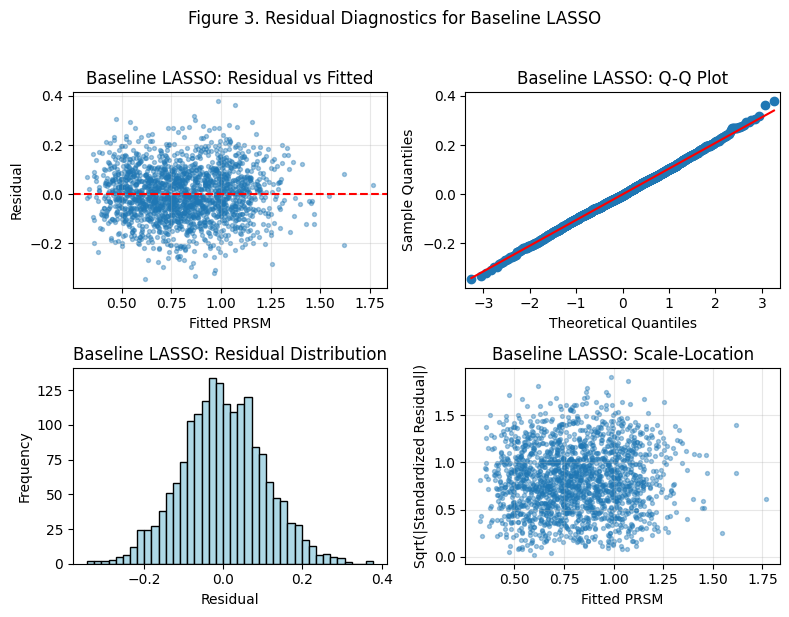

In [16]:
plot_residuals_diagnostics(residuals_baselineLASSO, fitted_baselineLASSO, 'Baseline LASSO', color='lightblue', name="Figure 3. Residual Diagnostics for Baseline LASSO")

# Analysis of Results

To facilitate interpretation, we first define a baseline borrower profile (Table 4a) by fixing all predictors at representative values (means for continuous variables and reference levels for categorical variables). The corresponding predicted PRSM for this baseline profile is 0.547 (Table 4b), which serves as a reference point for evaluating marginal effects.

Table 5 reports predictors with practically important effects, defined as changes in PRSM exceeding a pre-specified practical-effect threshold. The results indicate that ownership and business structure are the dominant drivers. In particular, transitioning from non–woman-owned to woman-owned is associated with an increase of 0.279 in PRSM, while LLC and partnership structures are associated with increases of 0.243 and 0.172, respectively. These effect sizes are substantially larger than those of other predictors, suggesting that business characteristics play a central role in repayment performance.

Financial variables such as FICO category and total amount owed also exhibit meaningful effects. For example, a two-category increase in FICO score corresponds to an increase of 0.110 in PRSM, indicating improved repayment performance for borrowers with stronger credit profiles. Similarly, higher total amount owed and stress levels are associated with moderate changes in PRSM, although their magnitudes are smaller relative to ownership and structure variables.

Table 6 presents predictors that are statistically significant but have small practical impact. For instance, corporate structure (Corp) and months in operation have estimated effects of 0.028 and 0.013, respectively. While these effects are statistically detectable (p-values near zero), their magnitudes are negligible in practical terms and therefore unlikely to materially influence decision-making.

Notably, the effect of months in operation is relatively small, suggesting that business tenure alone is not a strong predictor of repayment performance in this dataset. This may reflect the heterogeneity of small businesses, where longevity does not necessarily imply financial stability.

Overall, these results highlight the distinction between statistical significance and practical relevance. Variables such as business ownership and organizational structure have substantial influence on predicted PRSM, whereas other statistically significant variables contribute little to prediction in practical terms.

In [25]:
# Executive summary prep: baseline borrower + main drivers
practical_effect_threshold = 0.03

interpretation_specs = {
    'Baseline OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_baselineOLS_del,
        'scaler': None,
        'predictors': base_predictors,
        'train_X': X_train_base_del,
        'train_y': y_train_base_del,
    },
    'Baseline LASSO': {
        'model_type': 'LASSO',
        'model': model_baselineLASSO,
        'scaler': scaler_baselineLASSO,
        'predictors': base_predictors,
        'train_X': X_train_base_del,
        'train_y': y_train_base_del,
    },
    'Baseline Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_baselineStep,
        'scaler': None,
        'predictors': stepwise_predictors_baselineStep,
        'train_X': X_train_base_del[stepwise_predictors_baselineStep],
        'train_y': y_train_base_del,
    },
    'Preprocessed OLS (Trimmed)': {
        'model_type': 'OLS',
        'model': model_preOLS_del,
        'scaler': None,
        'predictors': preprocessed_predictors,
        'train_X': X_train_preprocessed_del,
        'train_y': y_train_preprocessed_del,
    },
    'Preprocessed Stepwise OLS': {
        'model_type': 'OLS',
        'model': model_preStep,
        'scaler': None,
        'predictors': stepwise_predictors_preStep,
        'train_X': X_train_preprocessed_del[stepwise_predictors_preStep],
        'train_y': y_train_preprocessed_del,
    },
    'Preprocessed LASSO': {
        'model_type': 'LASSO',
        'model': model_preLASSO,
        'scaler': scaler_preLASSO,
        'predictors': preprocessed_predictors,
        'train_X': X_train_preprocessed_del,
        'train_y': y_train_preprocessed_del,
    },
}

final_model_name = "Baseline LASSO"
selected_spec = interpretation_specs[final_model_name]
X_train_used = selected_spec['train_X'].copy()
y_train_used = selected_spec['train_y'].copy()


def round_for_profile(value: float) -> float:
    if abs(value) >= 100:
        return round(value, 0)
    if abs(value) >= 10:
        return round(value, 1)
    return round(value, 2)


def is_binary(series: pd.Series) -> bool:
    return set(np.unique(series.dropna())).issubset({0, 1})


baseline_profile = {}
for predictor in selected_spec['predictors']:
    series = X_train_used[predictor].dropna()
    if is_binary(series):
        baseline_profile[predictor] = int(series.mode().iloc[0])
    else:
        baseline_profile[predictor] = round_for_profile(float(series.median()))

baseline_df = pd.DataFrame([baseline_profile])[selected_spec['predictors']]

if selected_spec['model_type'] == 'OLS':
    coef_series = selected_spec['model'].params.drop('const', errors='ignore')
    pval_series = selected_spec['model'].pvalues.drop('const', errors='ignore')

    coefficient_table = pd.DataFrame({
        'predictor': coef_series.index,
        'coef': coef_series.values,
        'p_value': pval_series.reindex(coef_series.index).values,
    })
    baseline_pred = float(
        selected_spec['model']
        .predict(sm.add_constant(baseline_df, has_constant='add'))
        .iloc[0]
    )
else:
    original_scale_coef = selected_spec['model'].coef_ / selected_spec['scaler'].scale_
    coefficient_table = pd.DataFrame({
        'predictor': selected_spec['predictors'],
        'coef': original_scale_coef,
    })
    coefficient_table = coefficient_table[coefficient_table['coef'] != 0].copy()

    aux_X = sm.add_constant(X_train_used[coefficient_table['predictor']], has_constant='add')
    aux_ols = sm.OLS(y_train_used, aux_X).fit()
    aux_pvals = (
        aux_ols.pvalues
        .drop('const', errors='ignore')
        .rename('p_value')
        .reset_index()
        .rename(columns={'index': 'predictor'})
    )
    coefficient_table = coefficient_table.merge(aux_pvals, on='predictor', how='left')

    baseline_pred = float(
        selected_spec['model'].predict(selected_spec['scaler'].transform(baseline_df))[0]
    )

coefficient_table['StatSig5pct'] = coefficient_table['p_value'] < 0.05


def get_interpretation_step(series: pd.Series, baseline_value: float):
    if is_binary(series):
        if baseline_value == 0:
            return 1.0, '0 to 1'
        return -1.0, '1 to 0'

    iqr = float(series.quantile(0.75) - series.quantile(0.25))
    std = float(series.std())
    raw_step = iqr if iqr > 0 else (0.5 * std if std > 0 else 1.0)
    step = round_for_profile(raw_step)

    if step == 0:
        step = 1.0
    return step, f'+{step}'


rows = []
for _, row in coefficient_table.iterrows():
    predictor = row['predictor']
    coef = float(row['coef'])
    series = X_train_used[predictor].dropna()

    step, step_note = get_interpretation_step(series, baseline_profile[predictor])
    delta_prsm = coef * step

    rows.append({
        'Predictor': predictor,
        'ScenarioChange': step_note,
        'EstimatedDeltaPRSM': delta_prsm,
        'PValue': row['p_value'],
        'StatSig5pct': bool(row['StatSig5pct']),
        'Practical': abs(delta_prsm) >= practical_effect_threshold,
    })


driver_table = pd.DataFrame(rows).sort_values(
    'EstimatedDeltaPRSM',
    key=lambda col: np.abs(col),
    ascending=False,
)
main_drivers = driver_table[driver_table['Practical']].copy()
stat_not_practical = driver_table[
    driver_table['StatSig5pct']
    & (~driver_table['Practical'])
].copy()

summary_table = pd.DataFrame({
    'Metric': ['BaselinePredictedPRSM'],
    'Value': [baseline_pred],
}).round(3)
baseline_table = pd.DataFrame({
    'Predictor': baseline_df.columns,
    'BaselineValue': baseline_df.iloc[0].values,
}).round(3)
main_drivers_view = main_drivers[['Predictor', 'ScenarioChange', 'EstimatedDeltaPRSM', 'PValue', 'StatSig5pct']].round(3)
stat_not_practical_view = stat_not_practical[['Predictor', 'ScenarioChange', 'EstimatedDeltaPRSM', 'PValue']].round(3)
display_table(baseline_table, 'Table 4a. Baseline borrower profile')
display_table(summary_table, 'Table 4b. Baseline prediction')

display_table(main_drivers_view, 'Table 5. Practically important drivers')
display_table(stat_not_practical_view, 'Table 6. Statistically detectable but practically small effects')

**Table 4a. Baseline borrower profile**

,Predictor,BaselineValue
0,FICO_category,2.000
1,TotalAmtOwed,194674.000
2,Volume,84626.000
3,Stress,0.190
4,Num_CreditLines,10.000
5,Prop_Delinquent_Credit,0.400
6,WomanOwned,0.000
7,Months,18.000
8,CorpStructure_Corp,0.000
9,CorpStructure_LLC,0.000


**Table 4b. Baseline prediction**

,Metric,Value
0,BaselinePredictedPRSM,0.547


**Table 5. Practically important drivers**

,Predictor,ScenarioChange,EstimatedDeltaPRSM,PValue,StatSig5pct
6,WomanOwned,0 to 1,0.279,0.000,True
9,CorpStructure_LLC,0 to 1,0.243,0.000,True
10,CorpStructure_Partner,0 to 1,0.172,0.000,True
0,FICO_category,+2.0,0.110,0.000,True
1,TotalAmtOwed,+200985.0,0.100,0.000,True
3,Stress,+0.15,0.070,0.000,True


**Table 6. Statistically detectable but practically small effects**

,Predictor,ScenarioChange,EstimatedDeltaPRSM,PValue
8,CorpStructure_Corp,0 to 1,0.028,0.000
7,Months,+6.0,0.013,0.000
